## Environment setup

In [5]:
import glob, os
from functools import partial
import importlib

import tensorflow as tf

### Test data set preparation

In [6]:
import io_functions as io
importlib.reload(io)

from architecture_definitions import *

batchSize = 4096
nEpochs=1

testDataDir = "/scratch_ssd/akalinow/ProgrammingProjects/MachineLearning/OMTF/data/18_12_2020/" 
testFileNames = glob.glob(testDataDir+'OMTFHits_pats0x0003_newerSample_files_1_100_chunk_0.tfrecord.gzip')

dataset = io.get_LUT_NN_dataset(batchSize, nEpochs, testFileNames, 
                                nRefLayers=nRefLayers,
                                layer1_lut_size=layer1_lut_size,
                                layer2_lut_size=layer2_lut_size,
                                layer2_lutRangesCnt=layer2_lutRangesCnt,
                                last_input_is_bias=last_input_is_bias,
                                rangeFactor=rangeFactor,
                                isTrain=False)

Reading data from files:
/scratch_ssd/akalinow/ProgrammingProjects/MachineLearning/OMTF/data/18_12_2020/OMTFHits_pats0x0003_newerSample_files_1_100_chunk_0.tfrecord.gzip
CPU times: user 78.5 ms, sys: 1.29 ms, total: 79.8 ms
Wall time: 79.1 ms


### Load selected model version

In [8]:
import utility_functions as utils
importlib.reload(utils)

trainingSet = utils.getLatestModelPath(pattern="lut")
print("Using training set:",trainingSet)

job_dir = "results/"+trainingSet
os.makedirs(job_dir, exist_ok=True)

plot_dir = job_dir + "/figures"
os.makedirs(plot_dir, exist_ok=True)

checkpoint_path = "training/"+trainingSet

model = tf.keras.models.load_model(checkpoint_path)
model.summary()

Using training set: 2023_Mar_16_16_54_40_lut_16_8_1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Custom>LutInterLaye  (None, 16)               313344    
 r)                                                              
                                                                 
 layer2 (Custom>LutInterLaye  (None, 8)                36864     
 r)                                                              
                                                                 
 layer3 (Custom>LutInterLaye  (None, 1)                512       
 r)                                                              
                                                                 
Total params: 350,720
Trainable params: 327,936
Non-trainable params: 22,784
_________________________________________________________________


### Run the model and put the result into Pandas DataFrame

ptGenPtRec.shape (800, 800)
xedges.shape (801,)
yedges.shape (801,)
MeanAbsoluteError NN 21.889303
MeanAbsoluteError NN recalib. 25.13442916870117
MeanAbsoluteError OMTF 28.843176
MeanSquaredError NN 7485.456
MeanSquaredError NN recalib 10013.82016592063
MeanSquaredError OMTF 10181.163
CPU times: user 3.6 s, sys: 1.27 s, total: 4.86 s
Wall time: 3.14 s


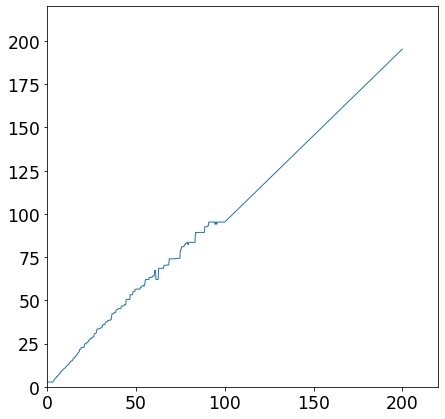

In [9]:
import utility_functions as utils
importlib.reload(utils)

import plotting_functions as plf
importlib.reload(plf)

modelAnswerPostProc = partial(utils.lutNNAnswerPostProc, output_type=output_type)

df = utils.df

for aBatch in dataset.take(10): 
    df = utils.fillPandasDataset(aBatch, df, model, modelAnswerPostProc)  
    
ptToPtCalibNN, xedges = plf.ptRecalibration(df, plot_dir, oneOverPt, "NN_pt")
df["NN_pt_recalib"] = plf.ptRecalibrated(df["NN_pt"], ptToPtCalibNN, xedges)     

### Make the plots

MeanAbsoluteError NN 21.889303
MeanAbsoluteError NN recalib. 25.13442916870117
MeanAbsoluteError OMTF 28.843176
MeanSquaredError NN 7485.456
MeanSquaredError NN recalib 10013.82016592063
MeanSquaredError OMTF 10181.163
ptCut: 10 qualityCut: 12, eff@plateau: 0.96
ptCut: 15 qualityCut: 12, eff@plateau: 0.96
ptCut: 20 qualityCut: 12, eff@plateau: 0.95
ptCut: 25 qualityCut: 12, eff@plateau: 0.93
ptCut: 30 qualityCut: 12, eff@plateau: 0.92
ptCut: 40 qualityCut: 12, eff@plateau: 0.90
rates NN @10 GeV:17560, @20 GeV: 3325


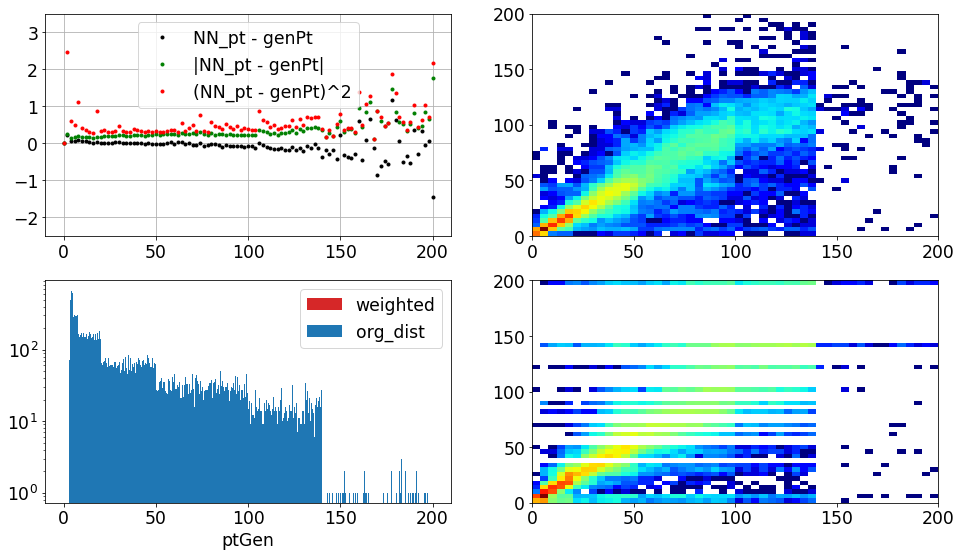

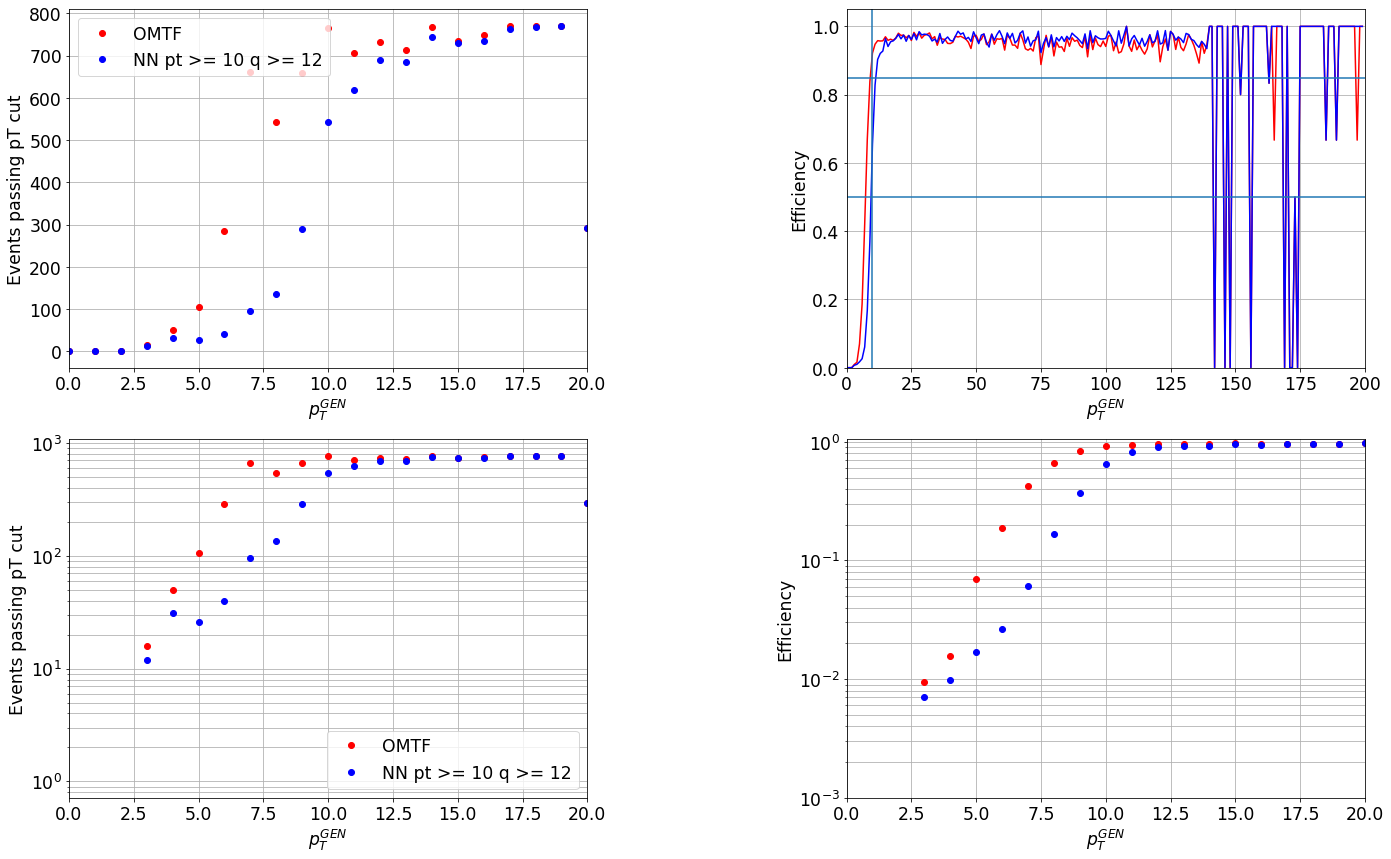

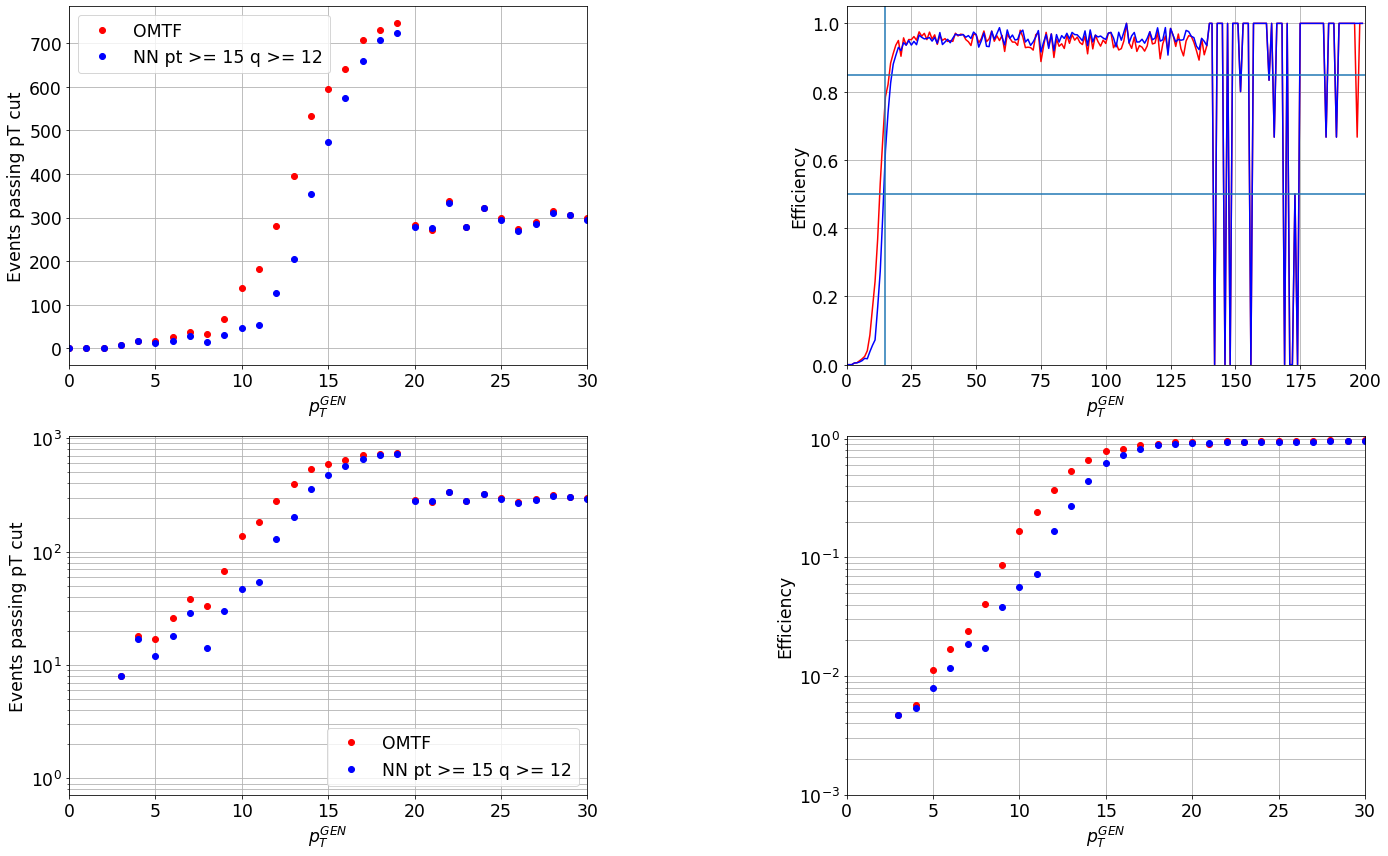

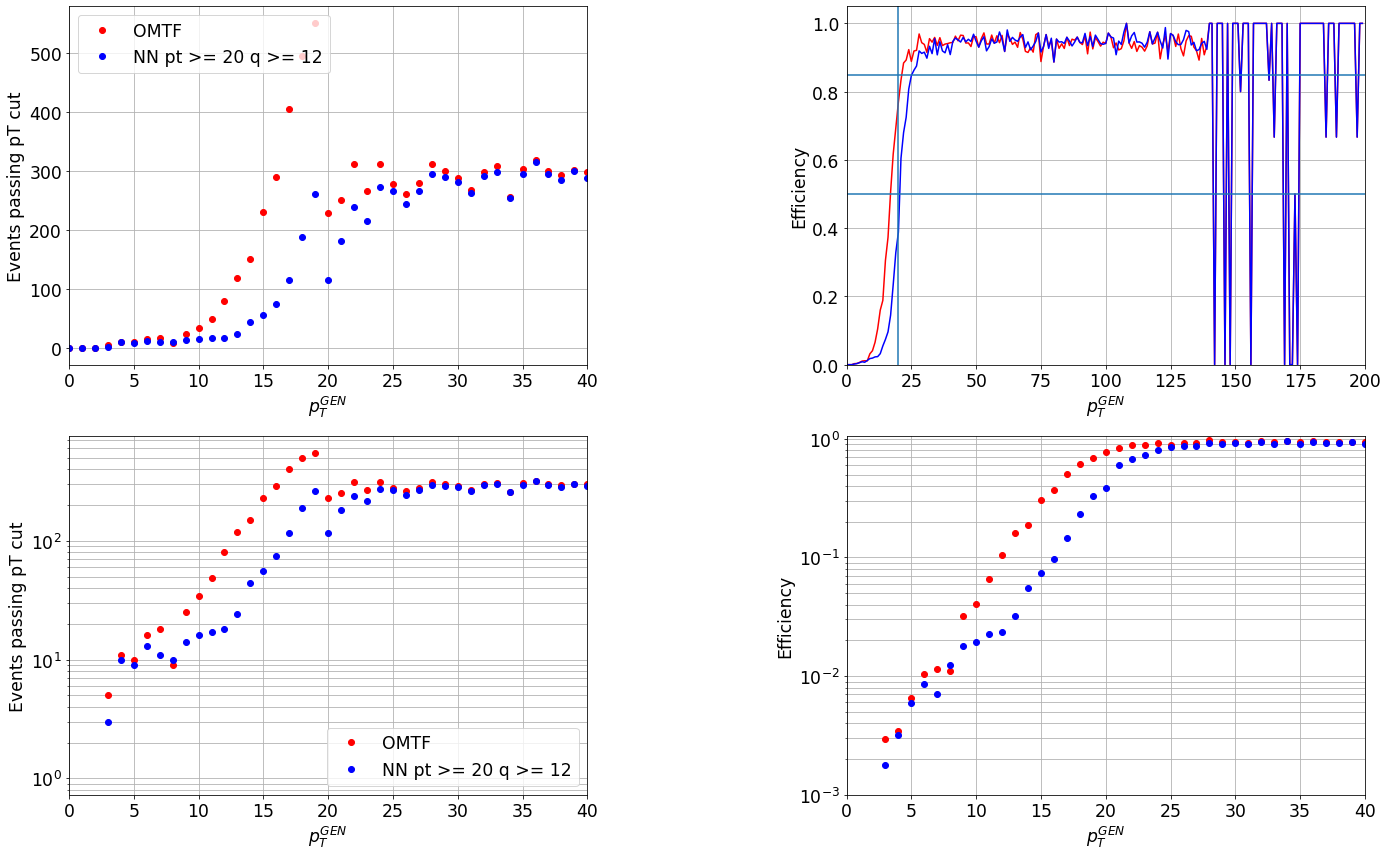

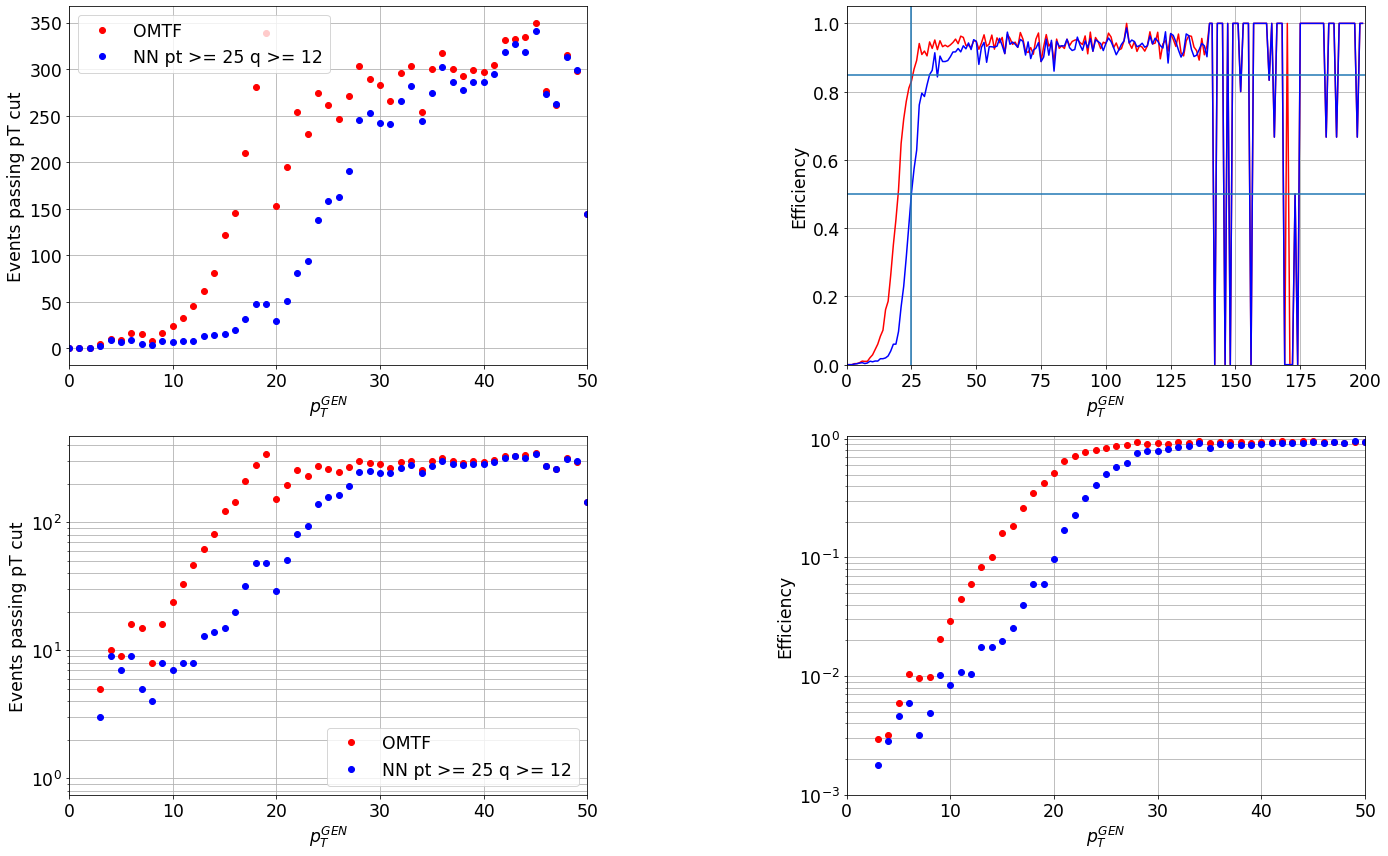

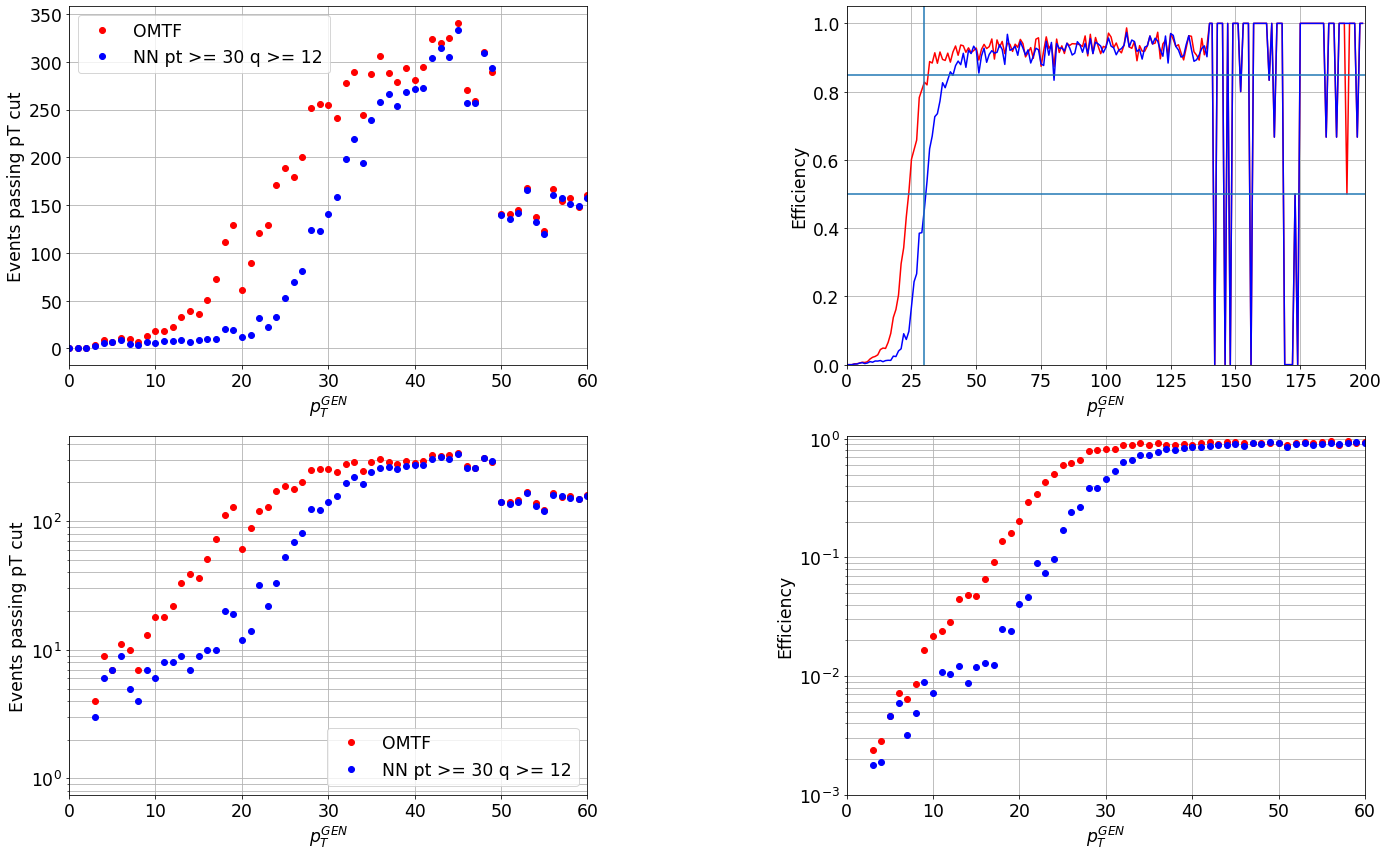

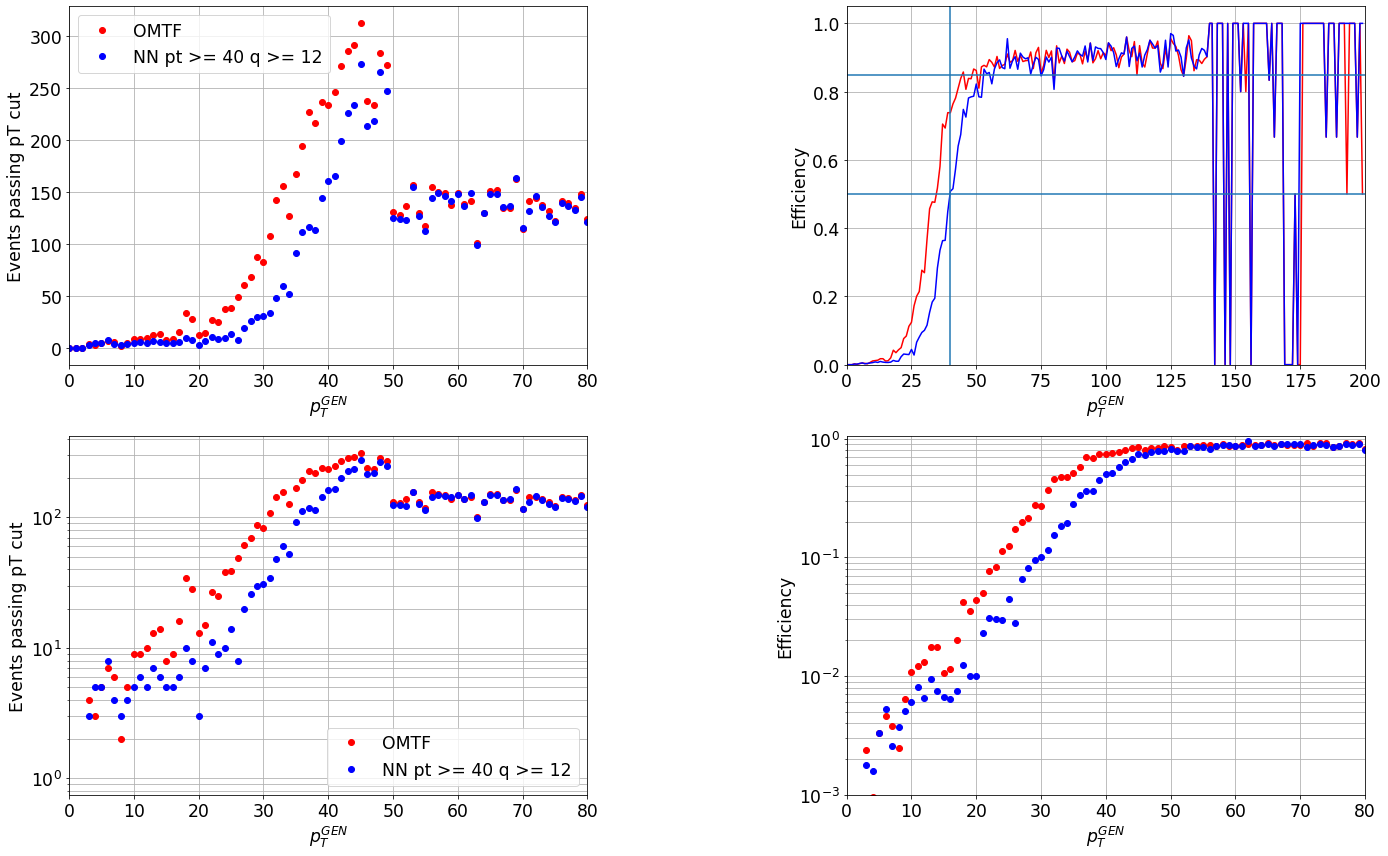

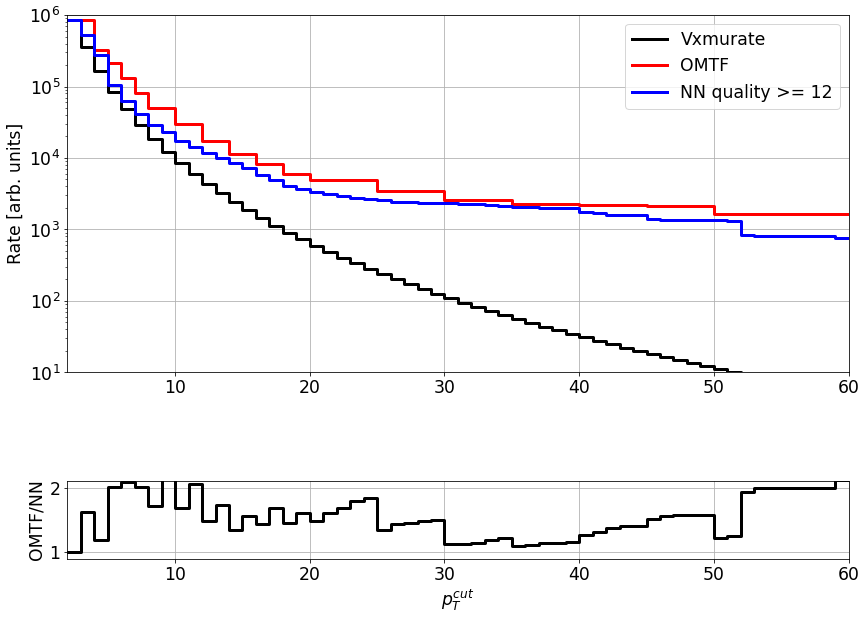

In [18]:
import plotting_functions as plf
importlib.reload(plf)

import utility_functions as utils
importlib.reload(utils)

fileName = job_dir+"/performance.txt"
utils.calculateLossFunctions(df, fileName)

plf.plotPtGenPtRec(df, plot_dir, oneOverPt)

for ptCut in plf.ptCuts :
    effStr, _, _ = plf.plotTurnOn(df, ptCut=ptCut, qualityCut = plf.qualityCut, plotDir=plot_dir)
    utils.appendStringToFile(effStr, fileName)
    print(effStr)

ratesStr = plf.plotRate(df, plf.qualityCut, plotDir=plot_dir)
print("rates NN", ratesStr)

utils.appendStringToFile(ratesStr, fileName)